https://www.kaggle.com/c/avazu-ctr-prediction/overview


<b>Input Data</b>
* train.csv     ≈40.4M
* test.csv      ≈4.58M

<b>Output(Expected Value)</b>
* id
* probability of click

<b>Features</b>
* id: ad identifier
* click: 0/1 for non-click/click
* hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
* C1 -- anonymized categorical variable
* banner_pos
* site_id
* site_domain
* site_category
* app_id
* app_domain
* app_category
* device_id
* device_ip
* device_model
* device_type
* device_conn_type
* C14-C21 -- anonymized categorical variablesid: ad identifier

<h1>Data前処理</h1>



In [1]:
import numpy as np
import matplotlib 
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas import Series,DataFrame
%matplotlib inline
matplotlib.style.use('ggplot')
import sklearn

from datetime import datetime
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
print(np.version.full_version)
print(matplotlib.__version__)
print(pd.__version__)
print(sklearn.__version__)

2019/04/23 10:29:19
1.16.3
2.1.1
0.23.4
0.20.3


In [2]:
data_types = {
    'id': np.str,
    'click': np.bool_,
    'hour': np.str,
    'C1': np.uint16,
    'banner_pos': np.uint16,
    'site_id': np.object,
    'site_domain': np.object,
    'site_category': np.object,
    'app_id': np.object,
    'app_domain': np.object,
    'app_category': np.object,
    'device_id': np.object,
    'device_ip': np.object,
    'device_model': np.object,
    'device_type': np.uint16,
    'device_conn_type': np.uint16,
    'C14': np.uint16,
    'C15': np.uint16,
    'C16': np.uint16,
    'C17': np.uint16,
    'C18': np.uint16,
    'C19': np.uint16,
    'C20': np.uint16,
    'C21': np.uint16    
}

In [3]:
## data reading
date_parser = lambda x: pd.datetime.strptime(x, '%y%m%d%H')

In [4]:
import random
n = 20  # every 100th line = 5% of the lines

def load_train_data():
    train_df = pd.read_csv('./avazu-ctr-prediction/train.csv',
                           skiprows=lambda i: i % n != 0,
                           dtype=data_types,
                           parse_dates=['hour'],
                           date_parser=date_parser)
    return train_df

In [5]:
%%time
train_df = load_train_data()

Wall time: 1min 2s


In [6]:
train_df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10004482643316086592,False,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,66a5f0f3,d9b5648e,...,1,0,21234,320,50,2434,3,163,34552,61
1,10007164336863914220,True,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,65535,79
2,10010924186026106882,False,2014-10-21,1005,0,030440fe,08ba7db9,76b2941d,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,65535,157
3,10013552540914034684,False,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,...,1,0,4687,320,50,423,2,39,34612,32
4,10015745448500295401,False,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,65535,79


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021448 entries, 0 to 2021447
Data columns (total 24 columns):
id                  object
click               bool
hour                datetime64[ns]
C1                  uint16
banner_pos          uint16
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type         uint16
device_conn_type    uint16
C14                 uint16
C15                 uint16
C16                 uint16
C17                 uint16
C18                 uint16
C19                 uint16
C20                 uint16
C21                 uint16
dtypes: bool(1), datetime64[ns](1), object(10), uint16(12)
memory usage: 217.8+ MB


In [8]:
%%time
## 1.init_dict
cols_counts = {}  
for col in data_types.keys():
    cols_counts[col] = train_df[col].value_counts()

for k, v in cols_counts.items():
    print("{} : {}".format(k, v.size))
    

id : 2021448
click : 2
hour : 240
C1 : 7
banner_pos : 7
site_id : 3055
site_domain : 3515
site_category : 23
app_id : 3955
app_domain : 244
app_category : 27
device_id : 281620
device_ip : 969997
device_model : 5755
device_type : 4
device_conn_type : 4
C14 : 2359
C15 : 8
C16 : 9
C17 : 426
C18 : 4
C19 : 66
C20 : 164
C21 : 60
Wall time: 5.89 s


<b>Exploratory Data Analysis and Feature Engineering</b>

■ID　　⇒featureにならない

In [9]:
%%time
train_df.shape[0] == train_df['id'].unique().shape[0]

Wall time: 726 ms


True

■click ⇒target value

False    0.830094
True     0.169906
Name: click, dtype: float64

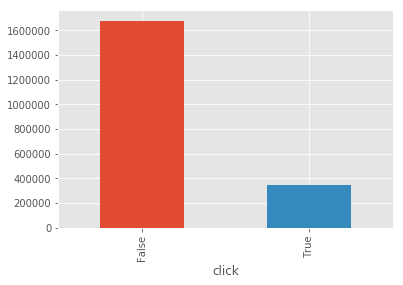

In [10]:
train_df.groupby('click').size().plot(kind='bar')
train_df['click'].value_counts() / train_df.shape[0]

■hour

* hour_day⇒feature
* day_week⇒feature


In [11]:
train_df.hour.describe()

count                 2021448
unique                    240
top       2014-10-22 09:00:00
freq                    22389
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

In [12]:
def derive_time_features(df, start_hour=None, remove_original_feature=False):
    if start_hour is None:
        start_hour = df['hour'][0]
        
    df['hour_int'] = train_df['hour'].apply(lambda x: np.floor((x - start_hour) / np.timedelta64(1, 'h')).astype(np.uint16))
    df['day_week'] = train_df['hour'].apply(lambda x: x.dayofweek)
    df['hour_day'] = train_df['hour'].apply(lambda x: x.hour)
    
    if remove_original_feature:
        df.drop('hour', axis=1, inplace=True)
    
    return df, start_hour

In [13]:
%%time
train_df, _ = derive_time_features(train_df)
train_df.head()

Wall time: 1min 18s


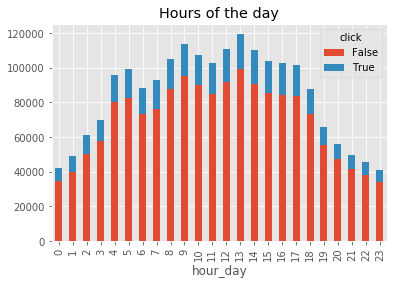

In [14]:
train_df.groupby(['hour_day', 'click']).size().unstack().plot(kind='bar', stacked=True, title="Hours of the day")

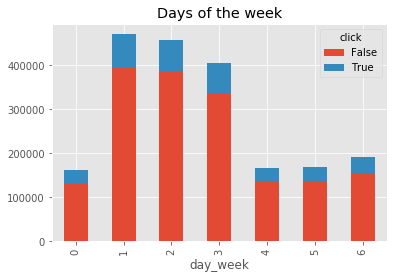

In [15]:
train_df.groupby(['day_week', 'click']).size().unstack().plot(kind='bar', stacked=True, title="Days of the week")

■banner_pos　⇒feature

In [16]:
train_df['banner_pos'].unique()

array([0, 1, 5, 2, 4, 7, 3], dtype=uint64)

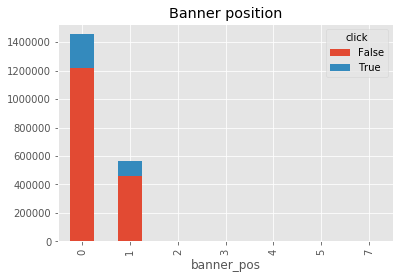

In [17]:
train_banner_pos_group_df = train_df.groupby(['banner_pos', 'click']).size().unstack()
train_banner_pos_group_df.plot(kind='bar', stacked=True, title='Banner position')


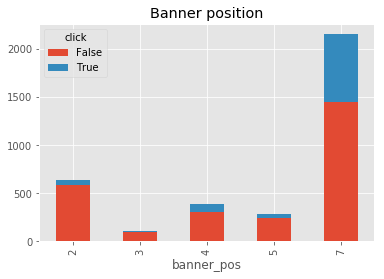

In [18]:
train_banner_pos_group_df.iloc[2:].plot(kind='bar', stacked=True, title='Banner position')

In [19]:
train_banner_pos_group_df / train_df.shape[0]

click,False,True
banner_pos,,
0,0.601696,0.118062
1,0.227065,0.051408
2,0.000291,0.000027
3,0.000046,0.000005
4,0.000153,0.000038
5,0.000123,0.000020
7,0.000720,0.000346


In [20]:
train_banner_pos_group_df.div(train_banner_pos_group_df.sum(axis=1), axis=0)

click,False,True
banner_pos,,
0,0.835969,0.164031
1,0.815393,0.184607
2,0.915888,0.084112
3,0.894231,0.105769
4,0.803109,0.196891
5,0.861111,0.138889
7,0.675174,0.324826


■Site-related features

In [21]:
site_features = ['site_id', 'site_domain', 'site_category']

train_df[site_features].describe()

,site_id,site_domain,site_category
count,2021448,2021448,2021448
unique,3055,3515,23
top,85f751fd,c4e18dd6,50e219e0
freq,730101,757020,827297


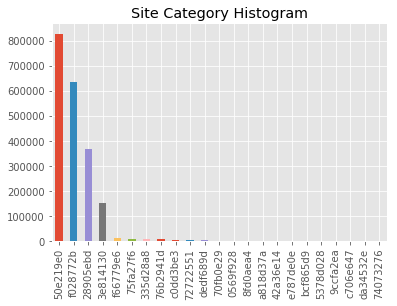

In [22]:
train_df['site_category'].value_counts().plot(kind='bar', title='Site Category Histogram')

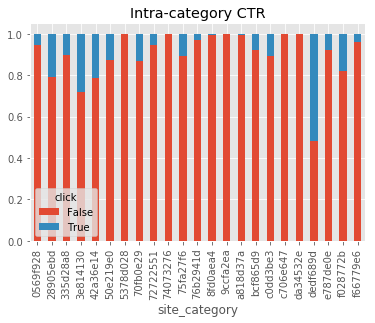

In [23]:
train_site_category_group_df = train_df.groupby(['site_category', 'click']).size().unstack()
train_site_category_group_df.div(train_site_category_group_df.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="Intra-category CTR")

■App-related features

In [24]:
app_features = ['app_id', 'app_domain', 'app_category']
train_df[app_features].describe()

,app_id,app_domain,app_category
count,2021448,2021448,2021448
unique,3955,244,27
top,ecad2386,7801e8d9,07d7df22
freq,1291347,1361526,1308012


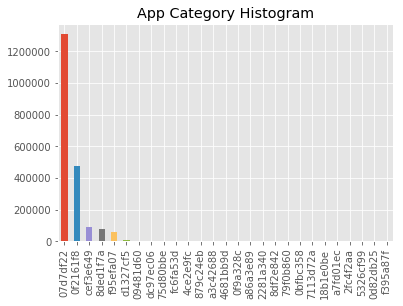

In [25]:
train_df['app_category'].value_counts().plot(kind='bar', title='App Category Histogram')

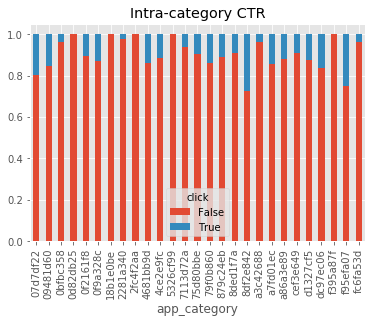

In [26]:
train_app_category_group_df = train_df.groupby(['app_category', 'click']).size().unstack()
train_app_category_group_df.div(train_app_category_group_df.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="Intra-category CTR")

■Device-related features

In [27]:
device_features = ['device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type']
train_df[device_features].astype('object').describe()

,device_id,device_ip,device_model,device_type,device_conn_type
count,2021448,2021448,2021448,2021448,2021448
unique,281620,969997,5755,4,4
top,a99f214a,6b9769f2,8a4875bd,1,0
freq,1667801,10554,122512,1865186,1744671


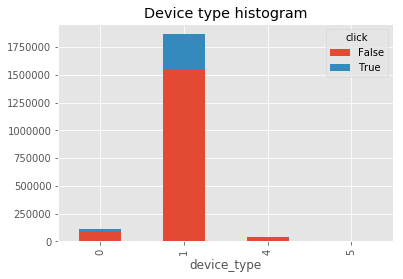

In [28]:
train_df.groupby(['device_type', 'click']).size().unstack().plot(kind='bar', stacked=True, title='Device type histogram')

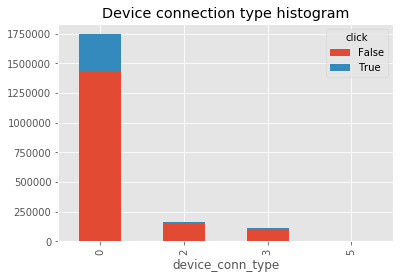

In [29]:
train_df.groupby(['device_conn_type', 'click']).size().unstack().plot(kind='bar', stacked=True, title='Device connection type histogram')

■C1, C14-C21

In [30]:
annonym_features = ['C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']
train_df[annonym_features].astype('object').describe()

,C1,C14,C15,C16,C17,C18,C19,C20,C21
count,2021448,2021448,2021448,2021448,2021448,2021448,2021448,2021448,2021448
unique,7,2359,8,9,426,4,66,164,60
top,1005,4687,320,50,1722,0,35,65535,23
freq,1856958,47536,1885815,1907364,225100,845468,607204,947019,445494


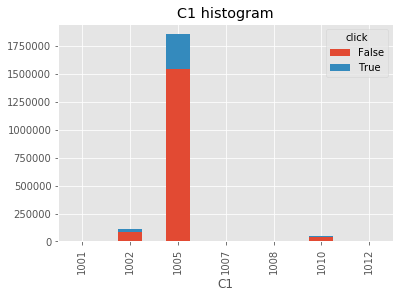

In [31]:
train_df.groupby(['C1', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')

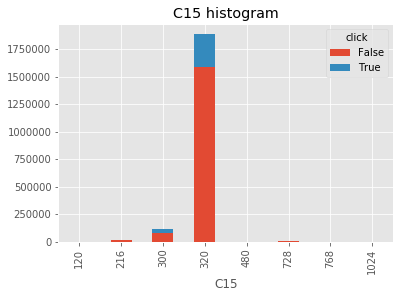

In [32]:
train_df.groupby(['C15', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C15 histogram')

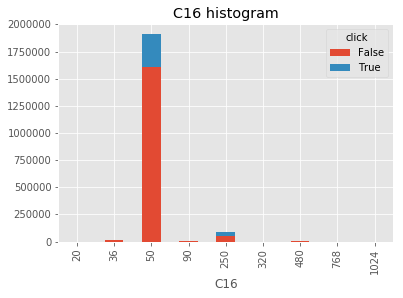

In [33]:
train_df.groupby(['C16', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C16 histogram')

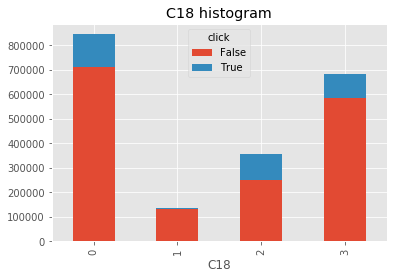

In [34]:
train_df.groupby(['C18', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C18 histogram')

<b>Prediction task</b>

In [85]:
features_mask = ['hour_int', 'day_week', 'hour_day', 'banner_pos', 'site_category']
target_mask = 'click'

In [87]:
train_sample_df = train_df[features_mask + [target_mask]].sample(frac=0.01, random_state=42)
train_sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20214 entries, 1133528 to 599324
Data columns (total 6 columns):
hour_int         20214 non-null int64
day_week         20214 non-null int64
hour_day         20214 non-null int64
banner_pos       20214 non-null uint16
site_category    20214 non-null object
click            20214 non-null bool
dtypes: bool(1), int64(3), object(1), uint16(1)
memory usage: 848.8+ KB


In [37]:
def one_hot_obj_features(df, features):
    new_df = pd.get_dummies(df, columns=features, sparse=True)
    return new_df

In [38]:
train_sample_df = one_hot_obj_features(train_sample_df, ['site_category', 'banner_pos'])
train_sample_df.head()

,hour_int,day_week,hour_day,click,site_category_0569f928,site_category_28905ebd,site_category_335d28a8,site_category_3e814130,site_category_42a36e14,site_category_50e219e0,...,site_category_e787de0e,site_category_f028772b,site_category_f66779e6,banner_pos_0,banner_pos_1,banner_pos_2,banner_pos_3,banner_pos_4,banner_pos_5,banner_pos_7
1133528,135,6,15,False,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
717146,79,4,7,True,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
325223,34,2,10,False,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2001601,236,3,20,False,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1802950,214,2,22,False,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [39]:
features_mask = np.array(train_sample_df.columns[train_sample_df.columns != target_mask].tolist())
features_mask

array(['hour_int', 'day_week', 'hour_day', 'site_category_0569f928',
       'site_category_28905ebd', 'site_category_335d28a8',
       'site_category_3e814130', 'site_category_42a36e14',
       'site_category_50e219e0', 'site_category_70fb0e29',
       'site_category_72722551', 'site_category_75fa27f6',
       'site_category_76b2941d', 'site_category_8fd0aea4',
       'site_category_a818d37a', 'site_category_c0dd3be3',
       'site_category_dedf689d', 'site_category_e787de0e',
       'site_category_f028772b', 'site_category_f66779e6', 'banner_pos_0',
       'banner_pos_1', 'banner_pos_2', 'banner_pos_3', 'banner_pos_4',
       'banner_pos_5', 'banner_pos_7'], dtype='<U22')

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    train_sample_df[features_mask].values, 
    train_sample_df[target_mask].values,
    stratify=train_sample_df[target_mask],
    test_size=0.3,
    random_state=42
)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14149, 27)
(6065, 27)
(14149,)
(6065,)


<b>SGDClassifier</b>

In [88]:
from sklearn.linear_model import SGDClassifier 

clf = SGDClassifier(loss='log', max_iter=10000, tol=1e-3)  # using log-loss for LogisticRegression
clf.fit(X_train, y_train)  # fitting

print('accuracy_score of train data: %.3f' % clf.score(X_train, y_train)) # 検証
print('accuracy_score of test data: %.3f' % clf.score(X_test, y_test)) # 検証

accuracy_score of train data: 0.832
accuracy_score of test data: 0.831


<b>LogisticRegression<b/>

In [81]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss

clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
clf.fit(X_train, y_train)
print('accuracy_score of train data: %.3f' % clf.score(X_train, y_train)) # 検証
print('accuracy_score of test data: %.3f' % clf.score(X_test, y_test)) # 検証

accuracy_score of train data: 0.833
accuracy_score of test data: 0.833


C:\Users\s.shin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
